In [1]:
import os
import ast
import torch
import scienceplots
import pickle as pkl
from collections import defaultdict
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
import pandas as pd
from plot_utils import plot_behavior_distribution
from data_utils import (
    results2df,
)
from plot_utils import plot_behavior_distribution

from torchmetrics.functional.classification import (
    multilabel_average_precision,
    multilabel_f1_score,
)
from matplotlib.colors import rgb2hex

**Data Loading**

In [2]:
metadata_file = "/home/dl18206/Desktop/phd/code/personal/facebook/slowfast/dataset/metadata/with_negative_pairing/new_metadata.csv"
behaviours_file = "../dataset/metadata/behaviours.txt"
segments_file = "../dataset/metadata/segments.txt"


metadata_df = pd.read_csv(metadata_file)

with open(behaviours_file, "rb") as f:
    behaviours = [beh.decode("utf-8").strip() for beh in f.readlines()]

with open(segments_file, "rb") as f:
    segments = [seg.decode("utf-8").strip() for seg in f.readlines()]

dummy_aps = [
    0.0235,
    0.0531,
    0.1467,
    0.1292,
    0.0346,
    0.2582,
    0.0776,
    0.1038,
    0.0155,
    0.0115,
    0.4553,
    0.1002,
    0.5724,
    0.0563,
]

In [3]:
def calculate_metrics(df, round_to=3, show_per_class=True):
    map_values = multilabel_average_precision(
        torch.tensor(np.stack(df["pred"])),
        torch.tensor(np.stack(df["label"])),
        num_labels=14,
        average="none",
        # thresholds=200,
    )
    avg_map = round(map_values.mean().item(), round_to)
    if show_per_class:
        map_values_list = []
        for v in map_values:
            map_v = round(v.item(), round_to)
            map_values_list.append(map_v)

        return map_values_list
    return avg_map


def calculate_imbalance_measures(df):
    counts = df["count"]
    total_samples = counts.sum()
    scaling_factor = np.log(total_samples)

    # 1. Gini coefficient
    def gini(x):
        x = np.sort(x)
        index = np.arange(1, len(x) + 1)
        return (np.sum((2 * index - len(x) - 1) * x)) / (len(x) * np.sum(x))

    gini_coefficient = gini(counts)

    # 2. Coefficient of variation
    cv = counts.std() / counts.mean()

    # 3. 80-20 rule (Pareto principle)
    sorted_counts = counts.sort_values(ascending=False)
    cumulative_sum = sorted_counts.cumsum()
    percentile_80 = np.interp(
        0.8 * total_samples, cumulative_sum, range(1, len(cumulative_sum) + 1)
    )
    pareto_ratio = percentile_80 / len(counts)

    # 4. Entropy-based measure
    probabilities = counts / total_samples
    entropy = stats.entropy(probabilities)
    max_entropy = np.log(len(counts))
    normalized_entropy = entropy / max_entropy
    imbalance_score = 1 - normalized_entropy

    return {
        "gini_coefficient": gini_coefficient,
        "scaled_gini_coefficient": gini_coefficient * scaling_factor,
        "coefficient_of_variation": cv,
        "scaled_coefficient_of_variation": cv * scaling_factor,
        "pareto_ratio": pareto_ratio,
        "scaled_pareto_ratio": pareto_ratio * scaling_factor,
        "imbalance_score": imbalance_score,
        "scaled_imbalance_score": imbalance_score * scaling_factor,
        "total_samples": total_samples,
    }

In [4]:
# Non specific train results (no split)
train_df = pd.read_csv(
    "/home/dl18206/Desktop/phd/code/personal/facebook/slowfast/dataset/annotations/standard/fg_only/standard/train.csv"
)
train_df.columns = ["name", "label"]

train_df = train_df.merge(
    metadata_df[["subject_id_fg", "utm"]], left_on="name", right_on="subject_id_fg"
)

train_df["label"] = train_df.label.apply(lambda x: ast.literal_eval(x))

In [5]:
val_results = "/home/dl18206/Desktop/phd/code/personal/facebook/slowfast/dataset/results/paper_results"

results_df = None

# Get paths to all pickle files
val_paths = []
for root, dirs, files in os.walk(val_results):
    for file in files:
        if file.endswith(".pkl"):
            val_paths.append(os.path.join(root, file))

for val_path in val_paths:

    col_name = val_path.split("/")[-2]

    with open(
        val_path,
        "rb",
    ) as f:
        val_data = pkl.load(f)

    _, val_df = results2df(val_data, val_data, metadata_df, right_on="subject_id_fg")

    if results_df is None:
        results_df = pd.DataFrame(
            {
                "behaviour": behaviours,
                "segment": segments,
                f"{col_name}": calculate_metrics(val_df),
            }
        )
    else:
        results_df[col_name] = calculate_metrics(val_df)

results_df["dummy_aps"] = dummy_aps

/home/dl18206/Desktop/phd/code/personal/facebook/slowfast/notebooks/data_utils.py:48: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  df["pred"] = df.pred.apply(lambda x: torch.sigmoid(torch.tensor(x)))
/home/dl18206/Desktop/phd/code/personal/facebook/slowfast/notebooks/data_utils.py:48: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  df["pred"] = df.pred.apply(lambda x: torch.sigmoid(torch.tensor(x)))
/home/dl18206/Desktop/phd/code/personal/facebook/slowfast/notebooks/data_utils.py:48: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  df["pred"]

In [6]:
bg_df = results_df[
    [
        "behaviour",
        "dummy_aps",
        "model=slow_r50_e300_bg-only",
        "model=slow_r50_e200_baseline_results",
    ]
]

bg_df["dummy_bg_diff"] = bg_df["model=slow_r50_e300_bg-only"] - bg_df["dummy_aps"]
bg_df["baseline_bg_diff"] = (
    bg_df["model=slow_r50_e200_baseline_results"] - bg_df["model=slow_r50_e300_bg-only"]
)

bg_df.sort_values(by=["dummy_bg_diff"], ascending=False)

<ipython-input-6-5383239396a8>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bg_df["dummy_bg_diff"] = bg_df["model=slow_r50_e300_bg-only"] - bg_df["dummy_aps"]
<ipython-input-6-5383239396a8>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bg_df["baseline_bg_diff"] = (


,behaviour,dummy_aps,model=slow_r50_e300_bg-only,model=slow_r50_e200_baseline_results,dummy_bg_diff,baseline_bg_diff
11,tool_use,0.1002,0.637,0.871,0.5368,0.234
5,feeding,0.2582,0.669,0.840,0.4108,0.171
3,climbing,0.1292,0.484,0.696,0.3548,0.212
4,display,0.0346,0.219,0.563,0.1844,0.344
10,resting,0.4553,0.623,0.772,0.1677,0.149
2,camera_reaction,0.1467,0.308,0.448,0.1613,0.140
7,object_carrying,0.1038,0.209,0.342,0.1052,0.133
0,aggression,0.0235,0.122,0.409,0.0985,0.287
13,vocalisation,0.0563,0.130,0.338,0.0737,0.208
6,grooming,0.0776,0.130,0.211,0.0524,0.081


In [7]:
bg_model = "/home/dl18206/Desktop/phd/code/personal/facebook/slowfast/dataset/results/paper_results/model=slow_r50_e300_bg-only/model=slow_r50_e300_bg-only_feats.pkl"
baseline_model = "/home/dl18206/Desktop/phd/code/personal/facebook/slowfast/dataset/results/paper_results/model=slow_r50_e200_baseline_results/model=slow_r50_e200_baseline_results_feats.pkl"

with open(
    bg_model,
    "rb",
) as f:
    bg_feats = pkl.load(f)

with open(
    baseline_model,
    "rb",
) as f:
    baseline_feats = pkl.load(f)

In [8]:
bg_df = pd.DataFrame(
    {
        "name": list(bg_feats["names"]),
        "pred": list(bg_feats["preds"].detach().cpu().numpy()),
        "label": list(bg_feats["labels"].detach().cpu().numpy()),
    }
).merge(metadata_df[["subject_id_fg", "utm"]], left_on="name", right_on="subject_id_fg")

bl_df = pd.DataFrame(
    {
        "name": list(baseline_feats["names"]),
        "pred": list(baseline_feats["preds"].detach().cpu().numpy()),
        "label": list(baseline_feats["labels"].detach().cpu().numpy()),
    }
).merge(metadata_df[["subject_id_fg", "utm"]], left_on="name", right_on="subject_id_fg")

bg_df["pred"] = bg_df["pred"].apply(
    lambda x: torch.sigmoid(torch.tensor(x)).detach().cpu().numpy()
)
bl_df["pred"] = bl_df["pred"].apply(
    lambda x: torch.sigmoid(torch.tensor(x)).detach().cpu().numpy()
)

In [9]:
# Which samples does the model predict tool use for?

In [10]:
def get_pred_and_cls(x, cls, thresh):
    idx = behaviours.index(cls)
    l = True if x["label"][idx] == 1.0 else False
    p = True if x["pred"][idx] >= thresh else False
    return l and p


def get_pred_only(x, cls, thresh):
    idx = behaviours.index(cls)
    p = True if x["pred"][idx] >= thresh else False
    return p

In [11]:
# Here, we define correct as the number of samples where the model predicts tool use > 0.5 and the label is 1.0
bg_correct = bg_df[
    bg_df.apply(lambda x: get_pred_and_cls(x, "tool_use", 0.35), axis=1)
].name.values

bl_correct = bl_df[
    bl_df.apply(lambda x: get_pred_and_cls(x, "tool_use", 0.35), axis=1)
].name.values

print(f"BG model correct: {len(bg_correct)}")
print(f"Baseline model correct: {len(bl_correct)}")

BG model correct: 45
Baseline model correct: 82


In [12]:
for b in behaviours:
    utm_df = (
        train_df[train_df.label.apply(lambda x: x[behaviours.index(b)] == 1)]
        .utm.value_counts()
        .reset_index()
    )
    print(b, calculate_imbalance_measures(utm_df)["scaled_pareto_ratio"])

aggression 2.3791640561064495
bipedal 2.2058441588397946
camera_reaction 3.3080492054805064
climbing 2.3662040424890143
display 2.045571783208951
feeding 1.7084666763316685
grooming 2.9994070186271875
object_carrying 2.6691899581064136
piloerection 2.146651091616378
playing 2.196870333939593
resting 2.4811182145292543
tool_use 2.154432562730737
travel 3.361301109166521
vocalisation 2.7252206450790264


In [13]:
# Find the intersection of the two sets of videos
intersection = set(bg_correct).intersection(set(bl_correct))
print(f"Intersection: {len(intersection)}")

# Find the difference between the two sets of videos
diff = set(bg_correct).difference(set(bl_correct))
print(f"Difference: {len(diff)}")

# This show that the observed performance relates to the same set of videos
# The 3 videos not predicted by the baseline model are from locations unobserved at training time

Intersection: 42
Difference: 3


In [14]:
bg_df[bg_df.name.isin(intersection)].utm.value_counts()

utm
0605619_0244636    9
0698421_0598444    6
0685375_0649767    3
0606473_0246762    3
0607416_0248474    3
0688836_0647457    2
0485487_0566361    2
0484589_0566571    2
0257193_1291867    2
0262839_1290093    2
0486023_0569733    2
0687357_0648673    2
0544696_0820080    1
0263119_1291174    1
0263938_1291005    1
0686477_0649112    1
Name: count, dtype: int64

[  45   89  259  264   70  499  125  192   29   20  848  185 1081  103]


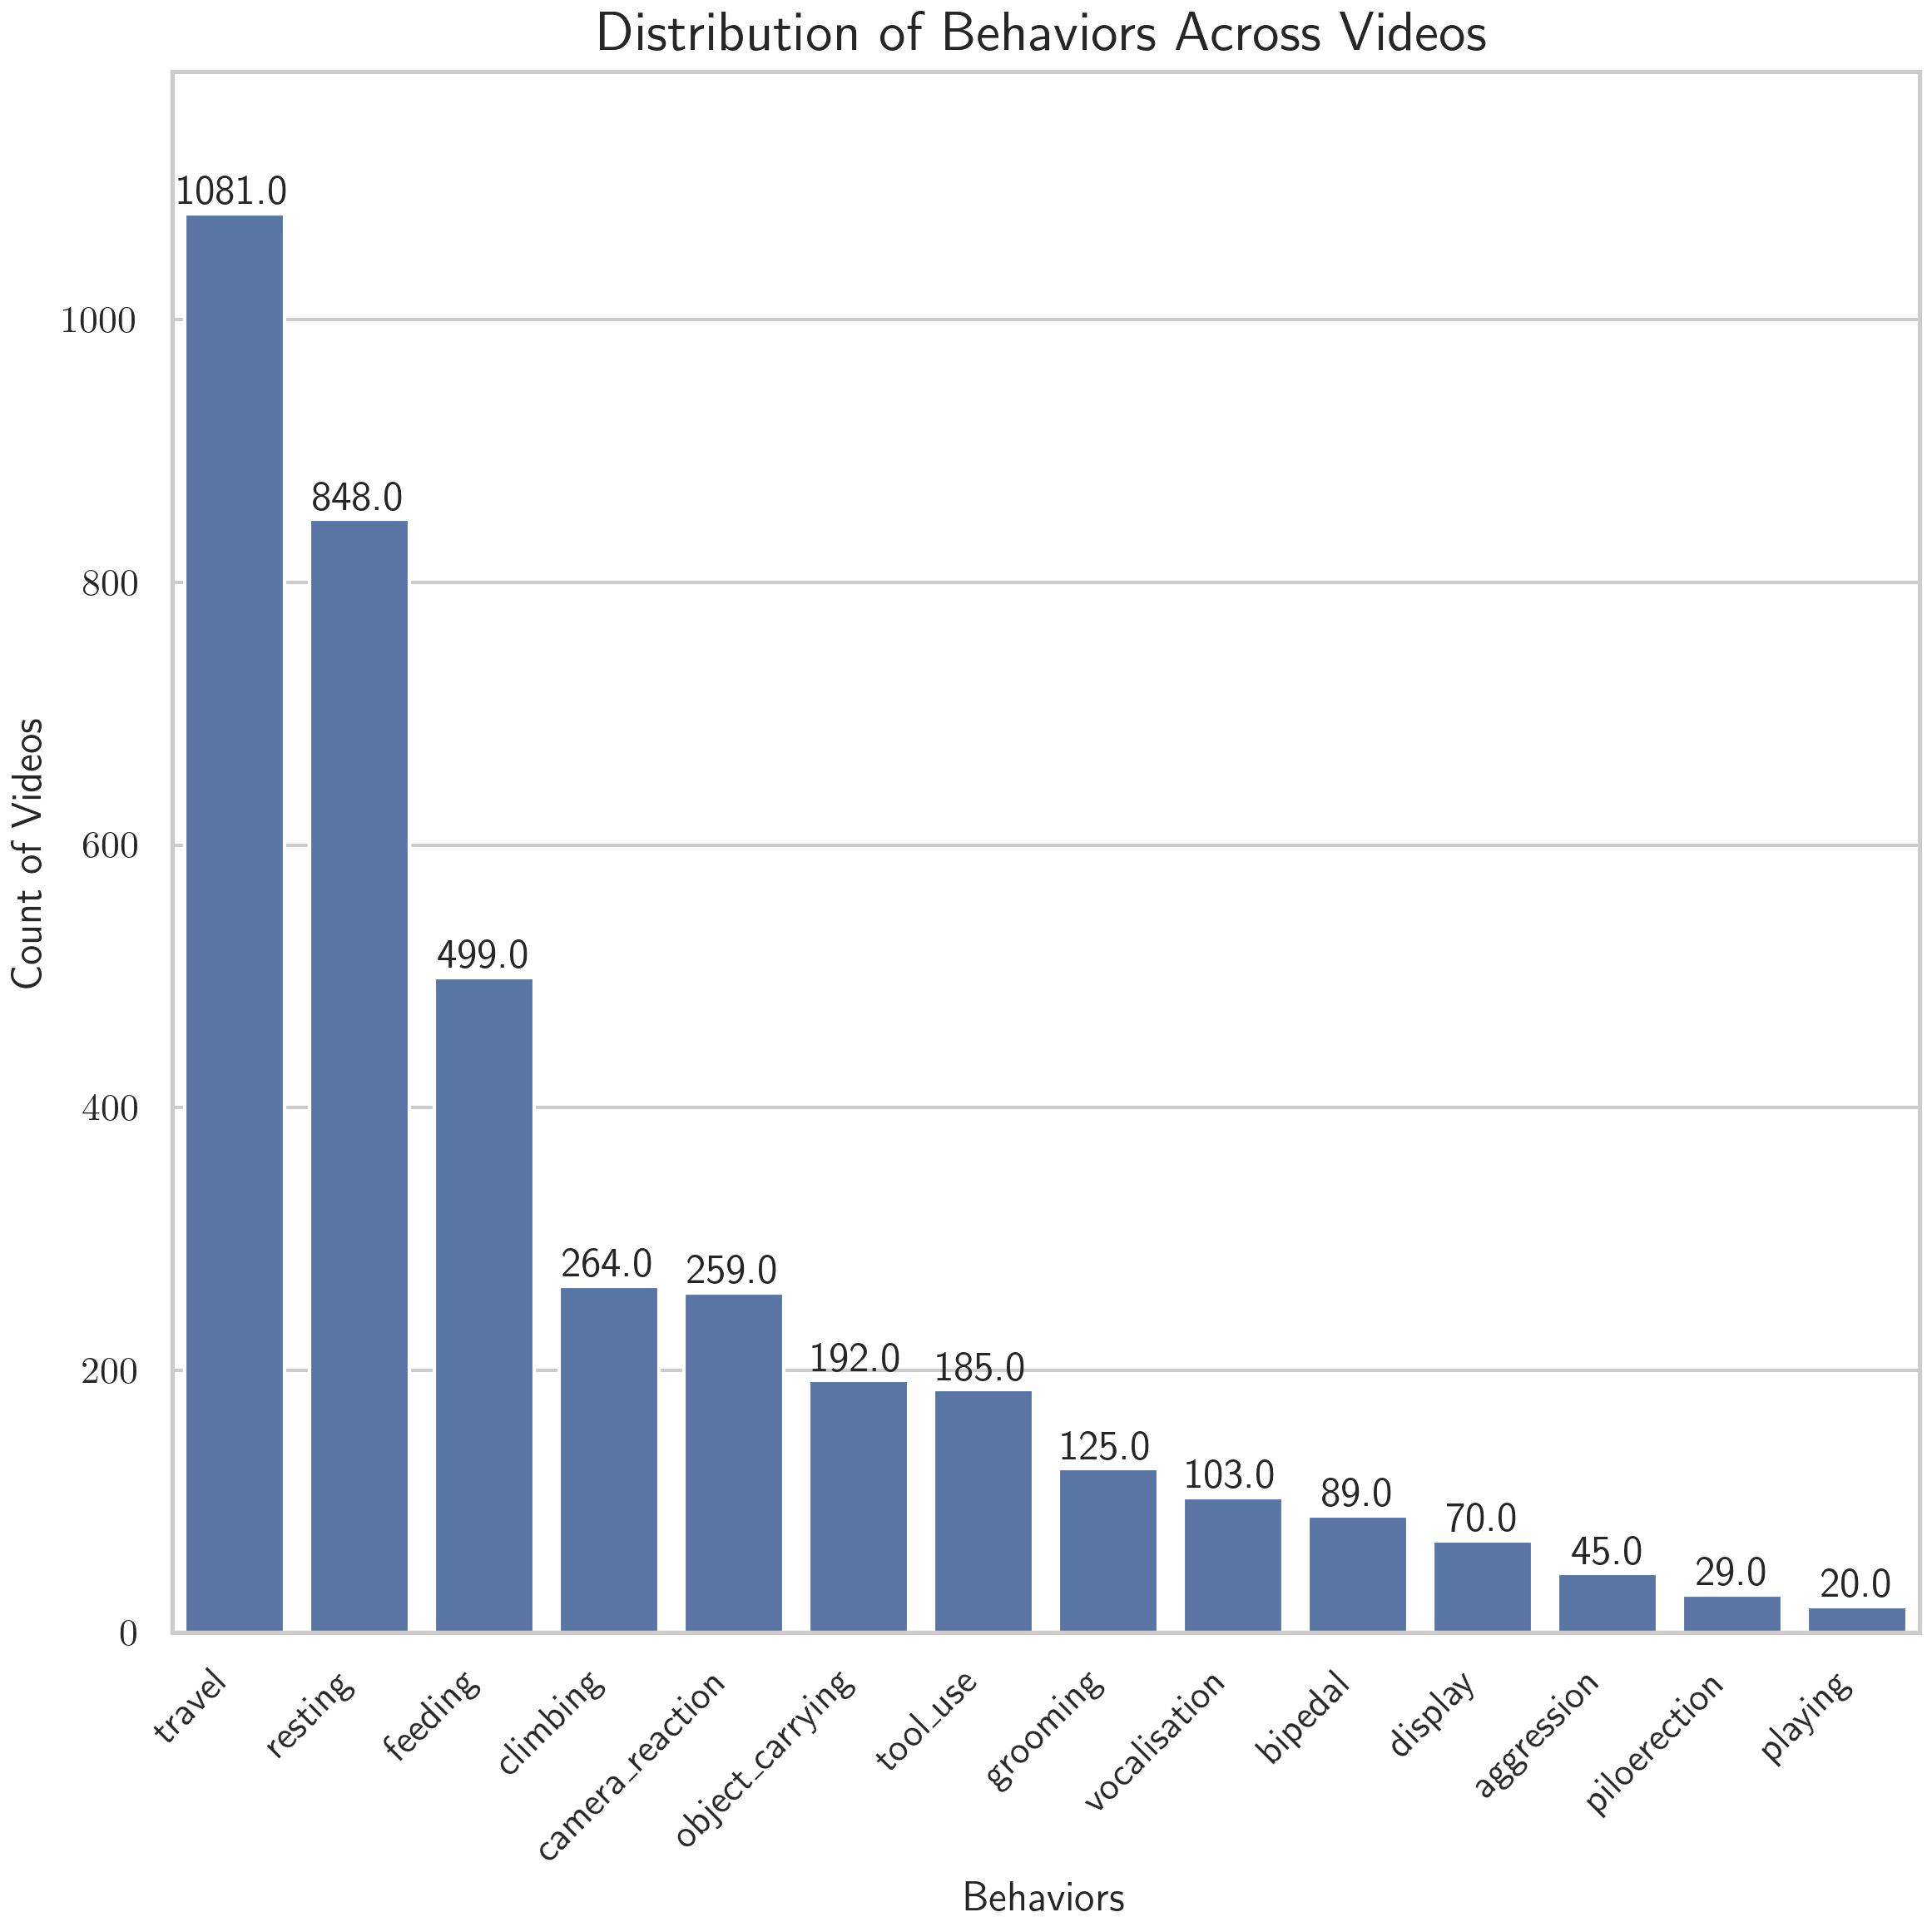

In [15]:
plot_behavior_distribution(train_df, behaviours, "count")

[  0   5  18   3   2 113  19  53   1   2  98 112  55   4]


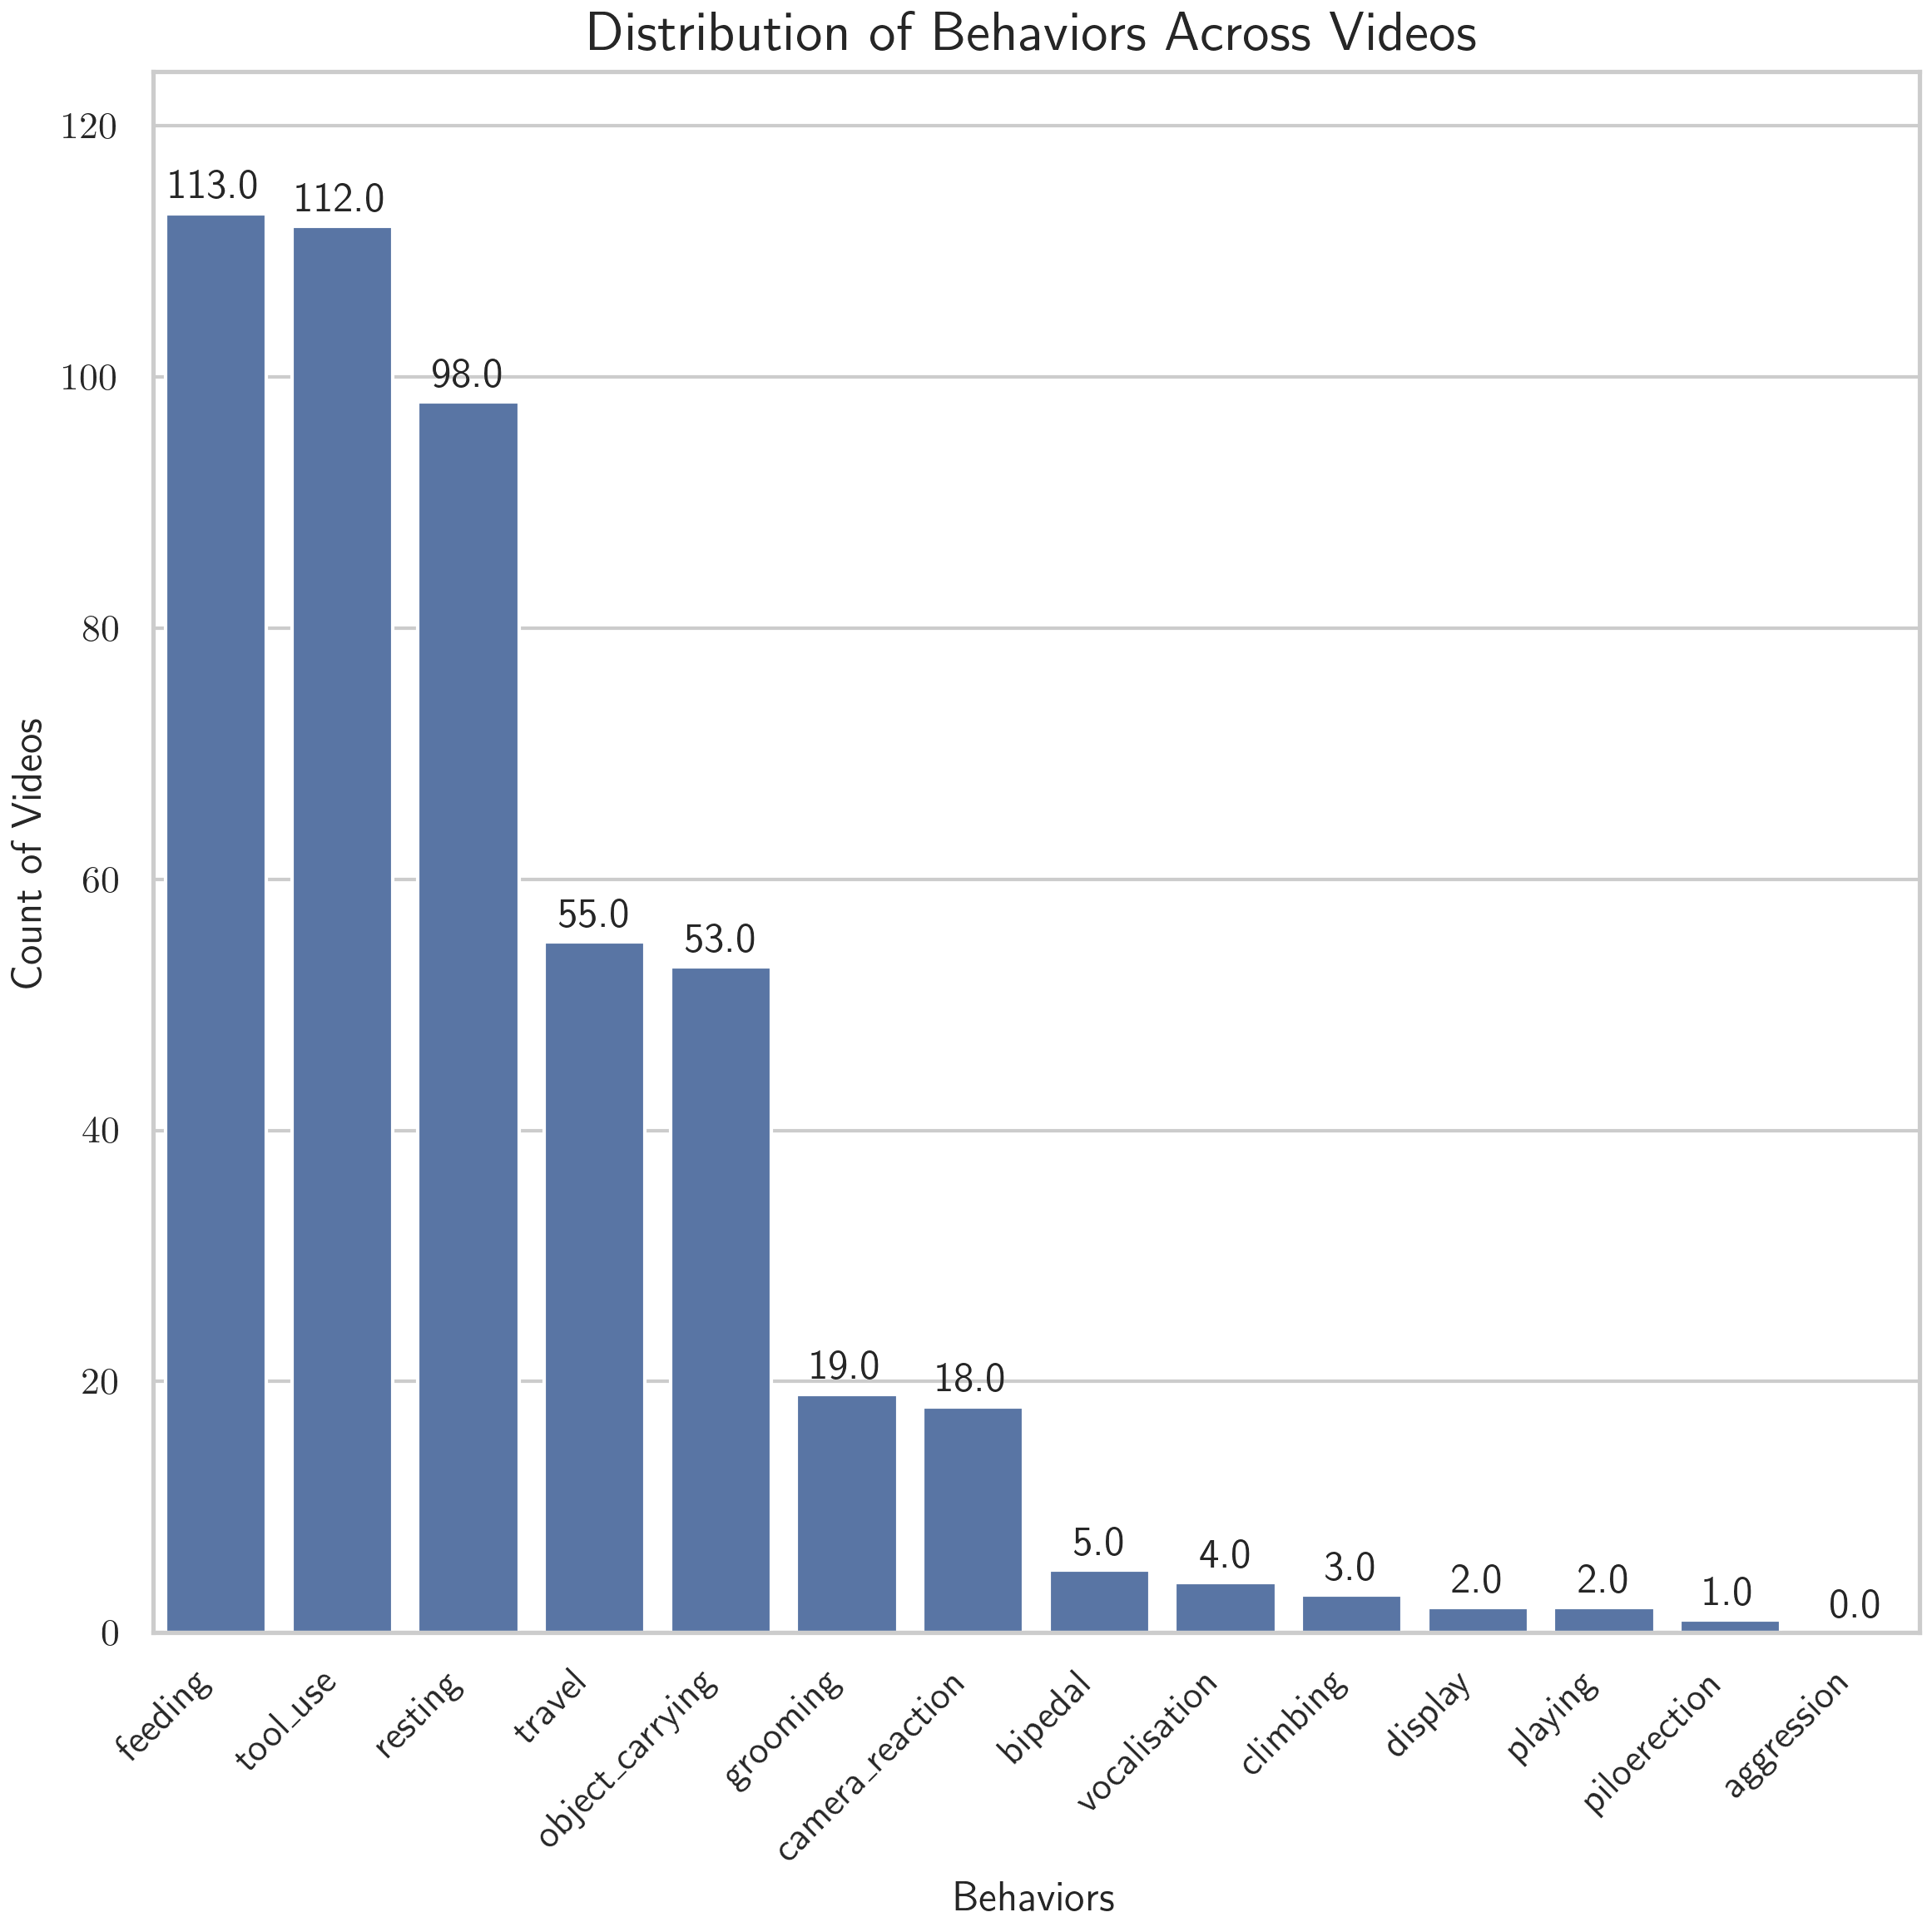

In [16]:
plot_behavior_distribution(
    train_df[train_df.utm.isin(bg_df[bg_df.name.isin(bg_correct)].utm.unique())],
    behavior_list=behaviours,
    annot="count",
)

In [18]:
def class_prevalence(df, cls):
    # Iterate through rows and count the number of times cls is present
    cls_count = 0
    for idx, row in df.iterrows():
        if row["label"][behaviours.index(cls)] == 1:
            cls_count += 1
    return cls_count / len(df)

In [21]:
class_prevalence(
    train_df[train_df.utm.isin(bg_df[bg_df.name.isin(bg_correct)].utm.unique())],
    "tool_use",
)

0.5161290322580645